# TESTEN IN DEZE CODE

Requirements:

- Pandas
- ScikitLearn
- Xgboost 
- Networkx
- NodeVectors (https://pypi.org/project/nodevectors/) 

install these packages via pip or conda

In [28]:
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
import networkx as nx
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import sklearn.metrics as slm
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score, log_loss
import os
from nodevectors import Node2Vec
import datetime as dt
import pickle
from sklearn.manifold import TSNE
import seaborn as sns
import numpy as np

In [29]:
base_path = "PATHNAME"
output_path = os.path.join(base_path, "output")
# dimensions of the embedding space #Default value
dimensionality = 64 #64
# Number of walks
walk_num = 10 #10
# length of walks
walk_len = 80 #80
# window_size (Word2Vec window size)
window_size = 5 #5

# number of parallel processes (number of CPU cores in your PC)
workers = 6

## Data

In [30]:
# Read dataset from disk
df = pd.read_csv('PATHNAME', sep=";", nrows=150000, decimal=',')

In [31]:
# create a unique transaction identifier:
df['TX_ID'] = ['t'+str(i) for i in range(df.shape[0])]

In [32]:
# Create train and test set
df_train = df.iloc[:100000]
df_test = df.iloc[100000:150000]

## Create a network

In [33]:
# Create a networkx Graph object
G = nx.Graph()

# Add 'merchant' nodes
G.add_nodes_from(df.TERM_MIDUID.unique(), type='merchant')
# Add 'cardholder' nodes
G.add_nodes_from(df.CARD_PAN_ID.unique(), type='cardholder')
# Add 'transaction' nodes
G.add_nodes_from(df.TX_ID.unique(), type='transaction')

## Assign weights ##

#Weight = Time
e = 2.71828
y = 0.03
#df['TX_DATETIME'] = pd.to_datetime(df['TX_DATETIME'])
#df['TX_INTTIME'] = df['TX_DATETIME'].apply(lambda x: x.timestamp())
#df['TX_INTTIME'] = df['TX_INTTIME']/(10**9) #minmaxscaler
#df['TX_INTTIME'] = df['TX_INTTIME']/(3600)
#df['TX_INTTIME'] = df['TX_INTTIME']/(24)
#df['TX_INTTIME'] = e**(y*df['TX_INTTIME'])

#MinMaxScaler
#df[['TX_INTTIME']] = MinMaxScaler().fit_transform(df[['TX_INTTIME']])
#f['TX_INTTIMESCALE'] = MinMaxScaler().fit_transform(df[['TX_INTTIME']])
#df['TX_INTTIMESCALE'] = e**(-y*df['TX_INTTIMESCALE'])

#Weight = Amount
#df['gewicht1'] = 1000
#df.loc[df['TX_AMOUNT'].between(0,df['TX_AMOUNT'].quantile(0.25)), 'gewicht1'] = 1
#df.loc[df['TX_AMOUNT'].between(df['TX_AMOUNT'].quantile(0.25),df['TX_AMOUNT'].quantile(0.5)), 'gewicht1'] = 10
#df.loc[df['TX_AMOUNT'].between(df['TX_AMOUNT'].quantile(0.5),df['TX_AMOUNT'].quantile(0.75)), 'gewicht1'] = 100

#Assign weight
#df['gewicht1'] = df['TX_AMOUNT']**2
#edge_weights = df['gewicht1']

# Connect each cardholder node to the transaction nodes he/she made
G.add_edges_from(zip(df.TX_ID,df.CARD_PAN_ID))
#G.add_weighted_edges_from(zip(df.TX_ID,df.CARD_PAN_ID,edge_weights))
# Connect each merchant node to the transaction nodes he/she made
G.add_edges_from(zip(df.TX_ID, df.TERM_MIDUID))
#G.add_weighted_edges_from(zip(df.TX_ID, df.TERM_MIDUID,edge_weights))

## Representation Learning

In [7]:
# Fit embedding model to graph
# This creates a vector for each node in the graph

g2v = Node2Vec(
    n_components=dimensionality,
    walklen = walk_len,
    epochs = walk_num,
    w2vparams={'workers': workers, 'window': window_size}
)

In [8]:
# Fit the embedding model to the graph with cardholders, merchants and transactions
# THIS MIGHT TAKE A WHILE! BE PATIENT! ;) 
g2v.fit(G)

Making walks... Done, T=64.50
Mapping Walk Names... Done, T=298.98
Training W2V... Done, T=1237.03


In [9]:
# Extract for each transaction node the embedding from the Node2Vec/Deepwalk model

embeddings = {}
model = g2v.model

# for each transaction
for i in df.TX_ID:
    # get the learned embedding and save it in a dictionary 'embeddings'
    embeddings[i] = model.wv[str(i)]

# turn the dictionary of embeddings into a pandas dataframe
embeddings = pd.DataFrame().from_dict(embeddings, orient='index')

In [10]:
# Add the embeddings to the train and test data
df_train = df_train.merge(embeddings, left_on='TX_ID', right_index=True)
df_test = df_test.merge(embeddings, left_on='TX_ID', right_index=True)

In [11]:
# OPTIONAL: save embeddings and node2vec/deepwalk model to diske

df_train.to_csv(os.path.join(output_path, 'df_train_deepwalk.csv'))
df_test.to_csv(os.path.join(output_path, 'df_test_deepwalk.csv'))
model.save(os.path.join(output_path, "node2vec.model"))

## tSNE

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 300000 samples in 0.020s...
[t-SNE] Computed neighbors for 300000 samples in 1263.838s...
[t-SNE] Computed conditional probabilities for sample 1000 / 300000
[t-SNE] Computed conditional probabilities for sample 2000 / 300000
[t-SNE] Computed conditional probabilities for sample 3000 / 300000
[t-SNE] Computed conditional probabilities for sample 4000 / 300000
[t-SNE] Computed conditional probabilities for sample 5000 / 300000
[t-SNE] Computed conditional probabilities for sample 6000 / 300000
[t-SNE] Computed conditional probabilities for sample 7000 / 300000
[t-SNE] Computed conditional probabilities for sample 8000 / 300000
[t-SNE] Computed conditional probabilities for sample 9000 / 300000
[t-SNE] Computed conditional probabilities for sample 10000 / 300000
[t-SNE] Computed conditional probabilities for sample 11000 / 300000
[t-SNE] Computed conditional probabilities for sample 12000 / 300000
[t-SNE] Computed conditional pro

[t-SNE] Computed conditional probabilities for sample 120000 / 300000
[t-SNE] Computed conditional probabilities for sample 121000 / 300000
[t-SNE] Computed conditional probabilities for sample 122000 / 300000
[t-SNE] Computed conditional probabilities for sample 123000 / 300000
[t-SNE] Computed conditional probabilities for sample 124000 / 300000
[t-SNE] Computed conditional probabilities for sample 125000 / 300000
[t-SNE] Computed conditional probabilities for sample 126000 / 300000
[t-SNE] Computed conditional probabilities for sample 127000 / 300000
[t-SNE] Computed conditional probabilities for sample 128000 / 300000
[t-SNE] Computed conditional probabilities for sample 129000 / 300000
[t-SNE] Computed conditional probabilities for sample 130000 / 300000
[t-SNE] Computed conditional probabilities for sample 131000 / 300000
[t-SNE] Computed conditional probabilities for sample 132000 / 300000
[t-SNE] Computed conditional probabilities for sample 133000 / 300000
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 246000 / 300000
[t-SNE] Computed conditional probabilities for sample 247000 / 300000
[t-SNE] Computed conditional probabilities for sample 248000 / 300000
[t-SNE] Computed conditional probabilities for sample 249000 / 300000
[t-SNE] Computed conditional probabilities for sample 250000 / 300000
[t-SNE] Computed conditional probabilities for sample 251000 / 300000
[t-SNE] Computed conditional probabilities for sample 252000 / 300000
[t-SNE] Computed conditional probabilities for sample 253000 / 300000
[t-SNE] Computed conditional probabilities for sample 254000 / 300000
[t-SNE] Computed conditional probabilities for sample 255000 / 300000
[t-SNE] Computed conditional probabilities for sample 256000 / 300000
[t-SNE] Computed conditional probabilities for sample 257000 / 300000
[t-SNE] Computed conditional probabilities for sample 258000 / 300000
[t-SNE] Computed conditional probabilities for sample 259000 / 300000
[t-SNE] Computed con

[Text(0.5, 1.0, 'Fraud data T-SNE projection')]

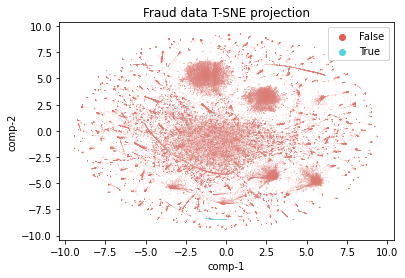

In [26]:
df["Markersize"] = 0.1
df.loc[df["TX_FRAUD"] == True, "Markersize"] = 25

x = embeddings.values
y = y = df.loc[:,'TX_FRAUD'].values

tsne = TSNE(n_components=2,verbose = 1 , random_state = 123,perplexity = 40, n_iter = 300)
z = tsne.fit_transform(x)
df = pd.DataFrame()
df["y"] = y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", s=df["Marksize"], hue=df.y.tolist(),
                palette=sns.color_palette("hls", 2),
                data=df).set(title="Fraud data T-SNE projection")


## PCA

In [13]:
df = pd.read_csv('PATHNAME', sep=";", nrows=150000, decimal=',')

x = embeddings.values
y = df.loc[:,'TX_FRAUD'].values
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf.head(5)

print (pca.explained_variance_ratio_)
print (np.sum(pca.explained_variance_ratio_))

[0.10369705 0.07700778]
0.18070482529289025


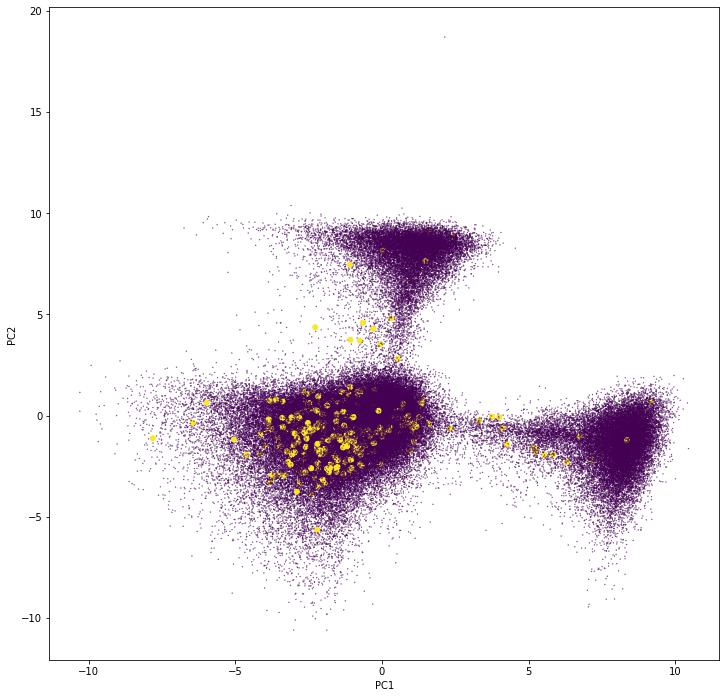

In [15]:
#Plot PCA
df["Markersize"] = 0.1
df.loc[df["TX_FRAUD"] == True, "Markersize"] = 25

plt.figure(figsize=(12,12))
plt.scatter(principalComponents[:,0], principalComponents[:,1], s = df["Markersize"], c = y)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

## Train a classification model

In [16]:
# the 'embeddings' have a column for each dimension. Hence, the embedding features take a number of columns equal to the number 
# of dimensions in the embedding space. 
embedding_features = [i for i in range(dimensionality)]
# you can add other columns to 'other features'
other_features = ['TX_AMOUNT']

In [17]:
# which features can the classifier use? Only embedding features for now. (You could add the 'other features' as well.)
features = embedding_features

In [18]:
# Divide training data into input features (X) and target (y).
X_train = df_train[features].iloc[:int(df_train.shape[0]*0.8)]
y_train = df_train.TX_FRAUD.iloc[:int(df_train.shape[0]*0.8)]

# a fraction of training data is used as validation data. 
X_val = df_train[features].iloc[int(df_train.shape[0]*0.8):]
y_val = df_train.TX_FRAUD.iloc[int(df_train.shape[0]*0.8):]

X_test = df_test[features]
y_test = df_test.TX_FRAUD

In [19]:
# Create DMatrix for XGBoost model. (this is specific for XGBoost)
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

In [20]:
# Parameters for XGBoost
xgb_params = {
    'n_jobs': workers,
    'learning_rate':0.1, 
    'colsample_bytree':0.6, 
    'colsample_bylevel':0.8,
    'subsample':0.9, 
    'eval_metric': ['auc','aucpr'],
    'objective':'binary:logistic', 
    'n_estimators':400,
    'seed':42}

In [21]:
# Train the XGBoost model on the training data (dtrain) and print validation metrics on validation data (dval)
model = xgb.train(xgb_params, dtrain, num_boost_round=xgb_params['n_estimators'], evals=[(dval, 'val')], early_stopping_rounds=int(xgb_params['n_estimators']/2))

[13:56:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	val-auc:0.84117	val-aucpr:0.35852
[1]	val-auc:0.84989	val-aucpr:0.51098
[2]	val-auc:0.85902	val-aucpr:0.55860
[3]	val-auc:0.86246	val-aucpr:0.56255
[4]	val-auc:0.86404	val-aucpr:0.56939
[5]	val-auc:0.86333	val-aucpr:0.56870
[6]	val-auc:0.87796	val-aucpr:0.58118
[7]	val-auc:0.87616	val-aucpr:0.57958
[8]	val-auc:0.87454	val-aucpr:0.58232
[9]	val-auc:0.87428	val-aucpr:0.58593
[10]	val-auc:0.87498	val-aucpr:0.58872
[11]	val-auc:0.88235	val-aucpr:0.59501
[12]	val-auc:0.88534	val-aucpr:0.59522
[13]	val-auc:0.88383	val-aucpr:0.59488
[14]	val-auc:0.89459	val-aucpr:0.59491
[15]

In [22]:
# Make predictions for the test data
y_pred_proba = model.predict(dtest)

# Calculate average precision score
print(average_precision_score(y_test, y_pred_proba))
# Calculate roc_auc_score
print(roc_auc_score(y_test, y_pred_proba))
# Calculate Log loss
print(log_loss(y_test,y_pred_proba))

0.3439109981433335
0.9136646921381557
0.028246065679668225


## ROC curve

In [23]:
# Plot ROC curve
fpr,tpr,tresholds = slm.roc_curve(y_test.values,y_pred_proba)
roc_auc =roc_auc_score(y_test, y_pred_proba)


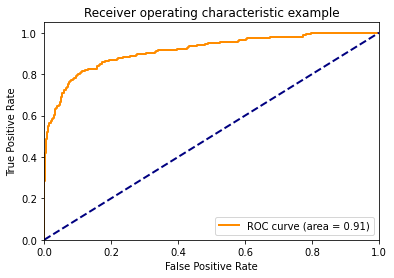

<Figure size 432x288 with 0 Axes>

In [24]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()
plt.savefig('roc curve weights = sliding window 2 75k')

In [25]:
# OPTIONAL: save model to file
filepath = os.path.join(output_path, 'xgb.model')
pickle.dump(model, open(filepath, "wb"))